In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image

In [2]:
# Load dataset
data = pd.read_csv('./Breast_Cancer.csv')

In [3]:
# Print The head of the data 
data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [4]:
#Printing the number of NULL elements
data.isnull().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [5]:
#Remove Row in Rows with NULL 
data = data.dropna()

In [6]:
#Describe the Data
data.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


In [7]:
#Encoding The Output
data['Status'] = data['Status'].map({'Alive': 1, 'Dead': 0})

In [8]:
#Dividing The Data As X And y
X = data.drop(columns=['Status'])
y = data['Status'].values
X = X.values

In [9]:
def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    split_index = int(X.shape[0] * (1 - test_size))
    
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [10]:
class DecisionTreeGini:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def gini(self, y):
        """Calculate Gini Impurity for a list of classes."""
        m = len(y)
        if m == 0:
            return 0
        class_counts = np.bincount(y)
        p = class_counts / m
        return 1 - np.sum(p ** 2)

    def split(self, X_column, threshold):
        """Split the data into two groups based on a threshold."""
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs

    def best_split(self, X, y):
        """Find the best feature and value to split on."""
        n_samples, n_features = X.shape
        best_gini = 1  # worst case Gini
        best_feature, best_threshold = None, None
        best_splits = None

        for feature in range(n_features):
            X_column = X[:, feature]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                left_idxs, right_idxs = self.split(X_column, threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                # Calculate the weighted Gini impurity for the split
                gini_left = self.gini(y[left_idxs])
                gini_right = self.gini(y[right_idxs])
                weighted_gini = (len(left_idxs) * gini_left + len(right_idxs) * gini_right) / n_samples

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
                    best_splits = (left_idxs, right_idxs)

        return best_feature, best_threshold, best_splits

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        n_samples, n_features = X.shape
        num_class_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth) or (num_class_labels == 1) or (n_samples < self.min_samples_split):
            most_common_label = np.bincount(y).argmax()
            return most_common_label

        # Find the best feature and threshold to split
        feature, threshold, (left_idxs, right_idxs) = self.best_split(X, y)

        if feature is None:
            return np.bincount(y).argmax()

        # Recur on left and right subtrees
        left = self.build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return {
            'feature': feature,
            'threshold': threshold,
            'left': left,
            'right': right
        }

    def fit(self, X, y):
        """Fit the tree on the data."""
        self.tree = self.build_tree(X, y)

    

    def predict_sample(self, x, tree):
        """Predict for a single sample."""
        if isinstance(tree, dict):
            feature = tree['feature']
            threshold = tree['threshold']
            if x[feature] <= threshold:
                return self.predict_sample(x, tree['left'])
            else:
                return self.predict_sample(x, tree['right'])
        else:
            return tree

    def predict(self, X):
        """Predict for all samples."""
        return np.array([self.predict_sample(x, self.tree) for x in X])

In [11]:
def accuracy_score(actual, predicted):
    """Calculate accuracy percentage using numpy."""
    actual = np.array(actual)
    predicted = np.array(predicted)
    correct = np.sum(actual == predicted)
    return (correct / len(actual)) * 100.0

In [12]:
def visualize_tree(tree, feature_names):
    """Visualize the decision tree using Graphviz."""
    def add_nodes_edges(dot, tree, node_id=0, depth=0):
        """Recursively add nodes and edges to the graph."""
        if isinstance(tree, dict):
            feature = feature_names[tree['feature']]
            threshold = tree['threshold']
            left_id = node_id * 2 + 1
            right_id = node_id * 2 + 2
            
            # Add the current node
            dot.node(str(node_id), f"{feature} <= {float(threshold):.2f}")

            # Recursively add the left and right children
            add_nodes_edges(dot, tree['left'], left_id, depth + 1)
            add_nodes_edges(dot, tree['right'], right_id, depth + 1)

            # Add edges to the children
            dot.edge(str(node_id), str(left_id))
            dot.edge(str(node_id), str(right_id))
        else:
            # Leaf node, add the class label
            dot.node(str(node_id), f"Class: {tree}", shape="box")

    dot = graphviz.Digraph()
    add_nodes_edges(dot, tree)
    return dot

In [13]:
#For Drawing the Decision Tree
def draw_tree(node, graph=None, parent=None, edge_label=""):
    """Recursive function to draw the decision tree using pygraphviz."""
    if graph is None:
        graph = pgv.AGraph(strict=False, directed=True)

    node_id = id(node)
    
    if isinstance(node, dict):
        # Add decision node
        graph.add_node(node_id, label=f"X{node['index']} < {node['value']}")
        
        if parent is not None:
            graph.add_edge(parent, node_id, label=edge_label)
        
        # Recur for left and right child nodes
        draw_tree(node['left'], graph, node_id, edge_label="True")
        draw_tree(node['right'], graph, node_id, edge_label="False")
    
    else:
        # Add terminal node (leaf)
        graph.add_node(node_id, label=f"Leaf: {node}", shape="box")
        if parent is not None:
            graph.add_edge(parent, node_id, label=edge_label)
    
    return graph

In [14]:
def simulate_epochs(X, y, epochs=20, max_depth_range=(1, 20)):
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    train_accuracies = []
    val_accuracies = []
    val_losses = []

    # Train the tree over simulated epochs by increasing the max depth
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        
        # Initialize the decision tree model with varying depth (simulating epochs)
        model = DecisionTreeGini(max_depth=epoch)  # Varying max_depth with epochs
        
        # Fit the model on training data
        model.fit(X_train, y_train)
        
        # Predictions on train and validation set
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # Calculate accuracy
        train_acc = accuracy_score(y_train, train_preds)
        val_acc = accuracy_score(y_val, val_preds)
        
        # Calculate validation loss (use Gini Impurity as loss)
        val_loss = model.gini(val_preds)
        
        # Append results for plotting later
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        # Visualize the tree
        # if(epoch==20):
        #     graph = draw_tree(model.tree)
        #     graph.layout(prog="dot")  # 'dot' layout is good for tree structures
        #     graph.draw("decision_tree.png")     
        print(f"Train Accuracy After {epoch} iterations : {train_acc:.4f}\nVal Accuracy After {epoch} iterations: {val_acc:.4f}\nVal Loss (Gini) After {epoch} iterations: {val_loss:.4f}")
    return train_accuracies, val_accuracies, val_losses

epochs = list(range(1, 21))
train_accuracies, val_accuracies, val_losses = simulate_epochs(X, y, epochs=20)

Epoch 1/20
Train Accuracy After 1 iterations : 90.3075
Val Accuracy After 1 iterations: 88.4472
Val Loss (Gini) After 1 iterations: 0.2044
Epoch 2/20
Train Accuracy After 2 iterations : 90.3075
Val Accuracy After 2 iterations: 88.4472
Val Loss (Gini) After 2 iterations: 0.2044
Epoch 3/20
Train Accuracy After 3 iterations : 90.7114
Val Accuracy After 3 iterations: 88.4472
Val Loss (Gini) After 3 iterations: 0.1316
Epoch 4/20
Train Accuracy After 4 iterations : 91.4259
Val Accuracy After 4 iterations: 88.6957
Val Loss (Gini) After 4 iterations: 0.1608
Epoch 5/20
Train Accuracy After 5 iterations : 91.8298
Val Accuracy After 5 iterations: 88.0745
Val Loss (Gini) After 5 iterations: 0.1750
Epoch 6/20
Train Accuracy After 6 iterations : 92.3889
Val Accuracy After 6 iterations: 87.0807
Val Loss (Gini) After 6 iterations: 0.1908
Epoch 7/20
Train Accuracy After 7 iterations : 93.6005
Val Accuracy After 7 iterations: 87.4534
Val Loss (Gini) After 7 iterations: 0.1770
Epoch 8/20
Train Accuracy A

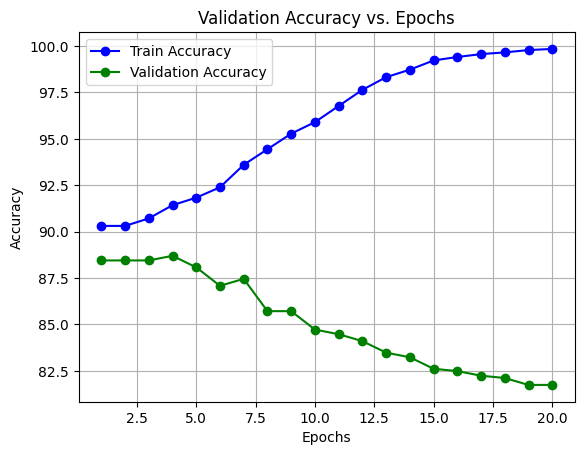

In [15]:
# Plot validation accuracy
plt.plot(epochs, train_accuracies, marker='o', color='b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, marker='o', color='g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.grid(True)
plt.legend()
plt.show()

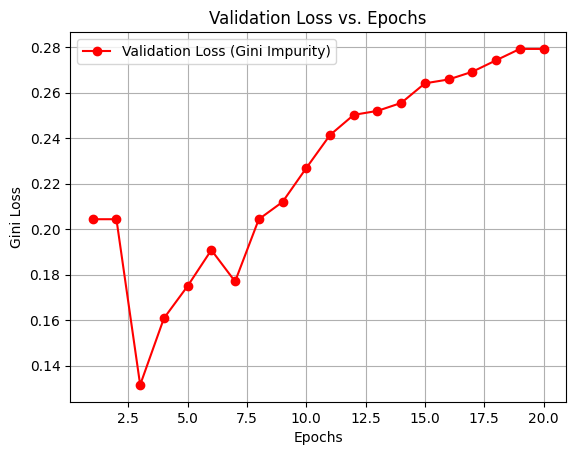

In [16]:
plt.plot(epochs, val_losses, marker='o', color='r', label='Validation Loss (Gini Impurity)')
plt.xlabel('Epochs')
plt.ylabel('Gini Loss')
plt.title('Validation Loss vs. Epochs')
plt.grid(True)
plt.legend()
plt.show()